# Importing Libraries

In [ ]:
import sys
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import pathlib
import warnings
import glob
import seaborn as sns
import joypy
import zipfile
import shutil
warnings.filterwarnings("ignore")

# Defining paths

In [2]:
# Deffining directories
current_dir = pathlib.Path().absolute()
fa_dir = current_dir.parents[0].joinpath('src')

# Importing fish_analyses module
sys.path.append(str(fa_dir))
import fish_analyses as fa

# Local folder path
local_folder_path = pathlib.Path().absolute().joinpath('temp_zip_analyses')
local_folder_path

# Path to credentials
desktop_path = pathlib.Path.home()/'Desktop'

# Connection to munsky-nas
path_to_config_file = desktop_path.joinpath('config.yml')
share_name = 'share'


## Mandatory substring that needs to be located on the file names

In [3]:
# Substring to contain in the folders to take them into account

mandatory_substring = 'nuc_120'


# List of folders to process

In [4]:
list_IL=(
'smFISH_images/Linda_smFISH_images/Confocal/20220125/GAPDH-Cy3_NFKBIA-Cy5_WO_IL-1B',
'smFISH_images/Linda_smFISH_images/Confocal/20220203/GAPDH-Cy3_NFKBIA-Cy5_5min_10ng_mL_IL-1B' ,
'smFISH_images/Linda_smFISH_images/Confocal/20220127/GAPDH-Cy3_NFKBIA-Cy5_10min_10ng_mL_IL-1B' ,
'smFISH_images/Linda_smFISH_images/Confocal/20220125/GAPDH-Cy3_NFKBIA-Cy5_15min_10ng_mL_IL-1B' ,
'smFISH_images/Linda_smFISH_images/Confocal/20220125/GAPDH-Cy3_NFKBIA-Cy5_20min_10ng_mL_IL-1B' ,
'smFISH_images/Linda_smFISH_images/Confocal/20220124/GAPDH-Cy3_NFKBIA-Cy5_30min_10ng_mL_IL-1B' ,
'smFISH_images/Linda_smFISH_images/Confocal/20220124/GAPDH-Cy3_NFKBIA-Cy5_1h_10ng_mL_IL-1B' ,
'smFISH_images/Linda_smFISH_images/Confocal/20220124/GAPDH-Cy3_NFKBIA-Cy5_2h_10ng_mL_IL-1B' ,
'smFISH_images/Linda_smFISH_images/Confocal/20220124/GAPDH-Cy3_NFKBIA-Cy5_3h_10ng_mL_IL-1B' ) 

In [5]:
condition_labels = [ 'wo','5min','10min','15min','20min','30min','1h', '2h','3h']
plot_title= "GAPDH-Cy3_NFKBIA-Cy5_IL-1B"
max_val_plots = 100

# Establishing connection to NAS and downloading zip files.

In [6]:
# This code iterates over all zip files in a remote directory and download them to a local directory
list_remote_files=[]
list_local_files =[]
for folder in list_IL:
    list_files = fa.NASConnection(path_to_config_file,share_name = share_name).read_files(folder,timeout=60)
    for file in list_files:
        if ('.zip' in file) and (mandatory_substring in file):   # add an argument with re conditions 
            # Listing all zip files
            zip_file_path = pathlib.Path().joinpath(folder,file)
            list_remote_files.append (zip_file_path)
            list_local_files.append(pathlib.Path().joinpath(local_folder_path,zip_file_path.name)) 
            # downloading the zip files from NAS
            fa.NASConnection(path_to_config_file,share_name = share_name).download_file(zip_file_path, local_folder_path,timeout=120)

Connection established
Connection established
Files downloaded to: /home/luisub/Desktop/FISH_Processing/notebooks/temp_zip_analyses/analysis_GAPDH-Cy3_NFKBIA-Cy5_WO_IL-1B___nuc_120__cyto_220__psfz_350__psfyx_120.zip
Connection established
Connection established
Files downloaded to: /home/luisub/Desktop/FISH_Processing/notebooks/temp_zip_analyses/analysis_GAPDH-Cy3_NFKBIA-Cy5_5min_10ng_mL_IL-1B___nuc_120__cyto_220__psfz_350__psfyx_120.zip
Connection established
Connection established
Files downloaded to: /home/luisub/Desktop/FISH_Processing/notebooks/temp_zip_analyses/analysis_GAPDH-Cy3_NFKBIA-Cy5_10min_10ng_mL_IL-1B___nuc_120__cyto_220__psfz_350__psfyx_120.zip
Connection established
Connection established
Files downloaded to: /home/luisub/Desktop/FISH_Processing/notebooks/temp_zip_analyses/analysis_GAPDH-Cy3_NFKBIA-Cy5_15min_10ng_mL_IL-1B___nuc_120__cyto_220__psfz_350__psfyx_120.zip
Connection established
Connection established
Files downloaded to: /home/luisub/Desktop/FISH_Processing/

# Unzipping Files

In [7]:
list_final_local_folders =[]
for zip_folder in list_local_files:
    # Reads from a list of zip files
    file_to_unzip = zipfile.ZipFile(str(zip_folder)) # opens zip
    temp_folder_name = pathlib.Path().joinpath(local_folder_path, zip_folder.stem)
    if (os.path.exists(temp_folder_name)) :
        shutil.rmtree(temp_folder_name)
        os.makedirs(temp_folder_name) # make a new directory
    # Iterates for each file in zip file
    for file_in_zip in file_to_unzip.namelist():
        # Extracts data to specific folder
        file_to_unzip.extract(file_in_zip,temp_folder_name)
    # Closes the zip file
    file_to_unzip.close()
    # removes the original zip file
    os.remove(pathlib.Path().joinpath(local_folder_path, zip_folder.name))
    list_final_local_folders.append(temp_folder_name)

In [8]:
def dataframe_extract_data(dataframe,spot_type_selected = 0, minimal_cluster_size=3):
    ''' This function is intended to read a dataframe and returns 
        number_of_spots_per_cell, number_of_spots_per_cell_cytosol, number_of_spots_per_cell_nucleus, number_of_TS_per_cell, ts_size, cell_size
    '''
    number_cells = dataframe['cell_id'].nunique()
    # Number of spots
    number_of_spots_per_cell = np.asarray([len( dataframe.loc[  (dataframe['cell_id']==i)  & (dataframe['spot_type']==spot_type_selected) ].spot_id) for i in range(0, number_cells)])
    # Number of spots in cytosol
    number_of_spots_per_cell_cytosol = np.asarray([len( dataframe.loc[  (dataframe['cell_id']==i) & (dataframe['is_nuc']==False) & (dataframe['spot_type']==spot_type_selected) ].spot_id) for i in range(0, number_cells)])
    # Number of spots in nucleus
    number_of_spots_per_cell_nucleus = np.asarray([len( dataframe.loc[  (dataframe['cell_id']==i) &  (dataframe['is_cluster']==False) & (dataframe['is_nuc']==True) & (dataframe['spot_type']==spot_type_selected)    ].spot_id) for i in range(0, number_cells)])
    # Total number of spots
    total_of_spots_per_cell_nucleus = np.asarray([len( dataframe.loc[  (dataframe['cell_id']==i) & (dataframe['spot_type']==spot_type_selected)    ].spot_id) for i in range(0, number_cells)])
    # Number of TS per cell.
    number_of_TS_per_cell = [len( dataframe.loc[  (dataframe['cell_id']==i) &  (dataframe['is_cluster']==True) & (dataframe['is_nuc']==True) & (dataframe['spot_type']==spot_type_selected) & (dataframe['cluster_size'] >=4) ].spot_id) for i in range(0, number_cells)]
    number_of_TS_per_cell= np.asarray(number_of_TS_per_cell)
    #number_of_TS_per_cell=number_of_TS_per_cell[number_of_TS_per_cell>minimal_cluster_size]   
    # Number of RNA in a TS
    ts_size =  dataframe.loc[   (dataframe['is_cluster']==True) & (dataframe['is_nuc']==True)  & (dataframe['spot_type']==spot_type_selected)   ].cluster_size.values
    # Size of each cell
    cell_size = np.asarray([len( dataframe.loc[  (dataframe['cell_id']==i) & (dataframe['spot_type']==0)].cell_area_px.values) for i in range(0, number_cells)])
    return number_of_spots_per_cell,number_of_spots_per_cell_cytosol,number_of_spots_per_cell_nucleus,number_of_TS_per_cell,ts_size,cell_size,number_cells,total_of_spots_per_cell_nucleus


In [9]:
data_dir = list_final_local_folders

In [10]:
list_spots_cell_conditions=[]
list_spots_nuc=[]
list_number_cells =[]
for i in range (0, len (data_dir)):
    dataframe_dir = current_dir.joinpath('analyses',data_dir[i])    # loading files from "analyses" folder
    dataframe_file = glob.glob( str(dataframe_dir.joinpath('dataframe_*')) )[0]
    dataframe_file
    df = pd.read_csv(dataframe_file) 
    number_of_spots_per_cell,number_of_spots_per_cell_cytosol,number_of_spots_per_cell_nucleus,number_of_TS_per_cell,ts_size,cell_size,number_cells,total_of_spots_per_cell_nucleus = dataframe_extract_data(df)
    list_spots_cell_conditions.append(total_of_spots_per_cell_nucleus)
    list_spots_nuc.append(number_of_spots_per_cell_nucleus)
    list_number_cells.append(number_cells)
    del number_of_spots_per_cell,number_of_spots_per_cell_cytosol,number_of_spots_per_cell_nucleus,number_of_TS_per_cell,ts_size,cell_size,number_cells,total_of_spots_per_cell_nucleus


In [11]:
print('number of cells in each dataset: ', list_number_cells)

number of cells in each dataset:  [604, 639, 542, 536, 562, 574, 625, 524, 535]


In [ ]:
# defining the dimensions for the array.
max_number_cells = max(list_number_cells)
number_conditions = len(list_number_cells)

In [ ]:
# creating an array with the same dimensions
spots_coditions_array = np.empty((max_number_cells,number_conditions))
spots_coditions_array[:] = np.NaN
# replace the elements in the array
for i in range(0,number_conditions ):
    spots_coditions_array[0:list_number_cells[i],i] = list_spots_cell_conditions[i] 
# creating a dataframe
df = pd.DataFrame(data=spots_coditions_array, columns=condition_labels)
df

# Plotting

In [ ]:
plt.figure(figsize=(10,5))
sns.set(font_scale = 1)
sns.set_style("whitegrid")
p_dist =sns.violinplot(data=df, scale="count",palette="OrRd")
p_dist.set_xlabel("Total count of spots per cell (nuc + cyto)")
p_dist.set_ylabel("Count")
p_dist.set_title(plot_title)
#p_dist.set_ylim(-10,max_val)
plt.savefig('Violin__'+plot_title+'.png', transparent=False)
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
sns.set(font_scale = 1)
sns.set_style("whitegrid")
p_dist =sns.kdeplot(data=df,palette="OrRd")
p_dist.set_xlabel("Total count of spots per cell (nuc + cyto)")
p_dist.set_ylabel("Kernel Density Estimator (KDE)")
p_dist.set_title(plot_title)
#sns.set(font_scale = 1)
p_dist.set_xlim(-10,max_val)
plt.savefig('Distributions__'+plot_title+'.png', transparent=False)
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
sns.set(font_scale = 1)
sns.set_style("whitegrid")
p_dist =sns.ecdfplot(data=df,palette="OrRd")
p_dist.set_xlabel("Total count of spots per cell (nuc + cyto)")
p_dist.set_ylabel("Proportion")
p_dist.set_title(plot_title)
p_dist.set_xlim(0,max_val)
plt.savefig('ECDF__'+ plot_title+'.png', transparent=False)
plt.show()

In [ ]:
plt.figure(figsize=(7,7))
sns.set(font_scale = 1.5)
sns.set_style("white")
p = sns.stripplot(data=df, size=3, color='0.5', jitter=0.2)
plt.xticks(rotation=45, ha="right")
sns.set(font_scale = 1.5)
#p.set_ylim(0,max_val)
bp=sns.boxplot( 
            meanprops={'visible': True,'color': 'r', 'ls': 'solid', 'lw': 4},
            #medianprops={'visible': False,'color': 'orangered', 'ls': 'solid', 'lw': 1},
            whiskerprops={'visible': True, 'color':'k','ls': 'solid', 'lw': 1},
            data=df,
            showcaps={'visible': False, 'color':'orangered', 'ls': 'solid', 'lw': 1}, # Q1-Q3 25-75%
            ax=p,
            showmeans=True,meanline=True,zorder=10,showfliers=False,showbox=True,linewidth=1,color='w')
p.set_xlabel("time_after_treatment")
p.set_ylabel("Total count of spots per cell (nuc + cyto)")
p.set_title(plot_title)
sns.set(font_scale = 1.5)
plt.savefig('BarPlots__'+plot_title+'.png', transparent=False)
plt.show()

In [ ]:
plt.style.use('ggplot')
fig, axes = joypy.joyplot(df,kind="counts", bins=40,range_style='own',
                          grid="y", linewidth=2, legend=False, figsize=(5,5),  
                          title="none",ylim='own',alpha=0.7,x_range=[-10.0,max_val],overlap=0,linecolor="k", color="k",
                          colormap=mpl.cm.Blues)
plt.title('Distributions', fontsize=12)
plt.xlabel('Counts', fontsize=12)
plt.ylabel('Conditions', fontsize=12)
plt.savefig('JoyPlots__'+plot_title+'.png', transparent=False)

# Moving plots to a final folder "comparing_distributions"

In [ ]:
# create results folder
destination_folder = 'comparing_distributions_'+plot_title

if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

plot_names = ['Violin__'+plot_title+'.png',
'Distributions__'+plot_title+'.png',
'BarPlots__'+plot_title+'.png',
'JoyPlots__'+plot_title+'.png',
'ECDF__'+plot_title+'.png']

#figure_path 
for name_plot in plot_names:
    pathlib.Path().absolute().joinpath(name_plot).rename(pathlib.Path().absolute().joinpath(destination_folder,name_plot))

In [12]:
df_complete = pd.DataFrame({
    'condition': condition_labels})
df_complete['number_spots'] = list_spots_cell_conditions
df_complete=df_complete.explode(['number_spots'])
df_complete

,condition,number_spots
0,wo,6
0,wo,22
0,wo,13
0,wo,38
0,wo,52
...,...,...
8,3h,34
8,3h,1
8,3h,26
8,3h,24


In [13]:
labels_df = df_complete.condition.unique()
labels_df

array(['wo', '5min', '10min', '15min', '20min', '30min', '1h', '2h', '3h'],
      dtype=object)

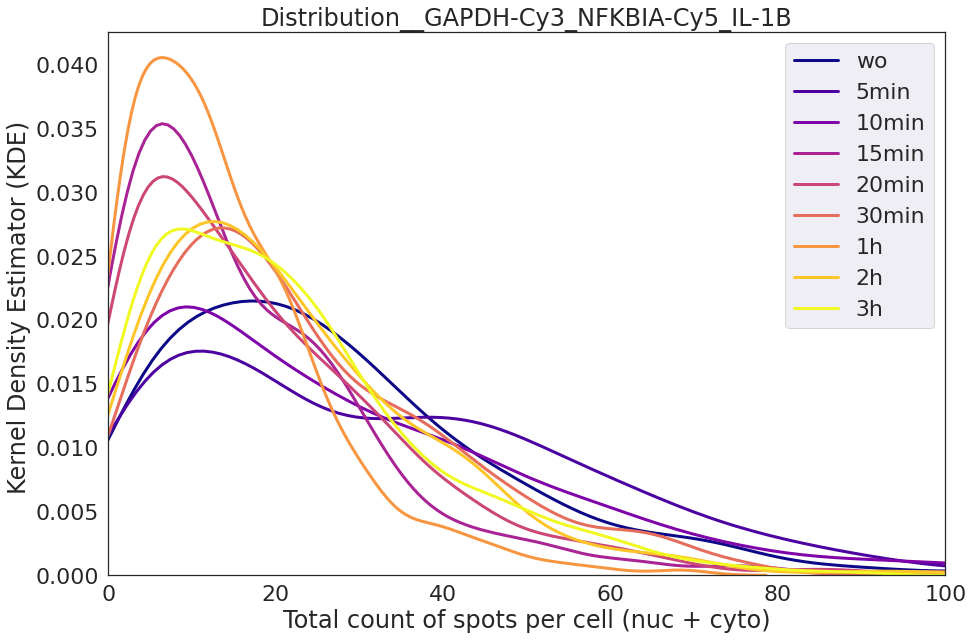

In [21]:
plt.figure(figsize=(15,10))
sns.set(font_scale = 2)
sns.set_style("white")
#color_lines = mpl.cm.autumn(np.linspace(0, 1, len(labels_df)))
#color_lines = mpl.cm.viridis(np.linspace(0, 1, len(labels_df)))
#color_lines = mpl.cm.Dark2(np.linspace(0, 1, len(labels_df)))
color_lines = mpl.cm.plasma(np.linspace(0, 1, len(labels_df)))
for i in range (0,len(labels_df)):
    p_dist = sns.kdeplot(df_complete.loc[df_complete['condition'] == labels_df[i]].number_spots.values,  linestyle='-',linewidth=3, color=color_lines[i] )
p_dist.set_xlabel("Total count of spots per cell (nuc + cyto)")
p_dist.set_ylabel("Kernel Density Estimator (KDE) ")
p_dist.set_title(plot_title)
p_dist.set_xlim(0,max_val_plots)
sns.set(font_scale = 2)
#plt.savefig(plot_title+'.png')
plt.legend(labels=labels_df)
plt.show()

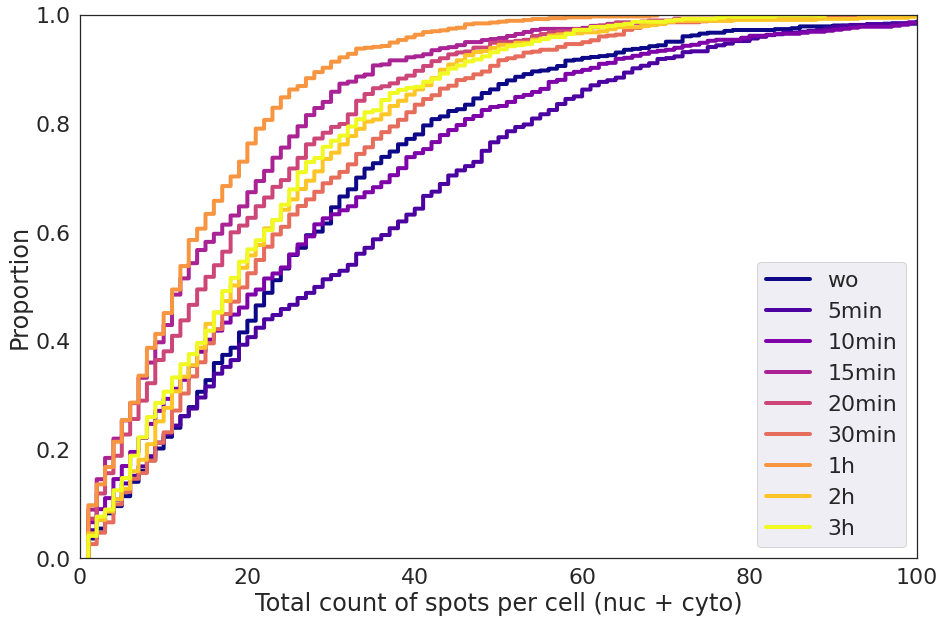

In [22]:
plt.figure(figsize=(15,10))
sns.set(font_scale = 2)
sns.set_style("white")
#color_lines = mpl.cm.autumn(np.linspace(0, 1, len(labels_df)))
#color_lines = mpl.cm.viridis(np.linspace(0, 1, len(labels_df)))
#color_lines = mpl.cm.Dark2(np.linspace(0, 1, len(labels_df)))
color_lines = mpl.cm.plasma(np.linspace(0, 1, len(labels_df)))
for i in range (0,len(labels_df)):
    p_dist = sns.ecdfplot(data=df_complete.loc[df_complete['condition'] == labels_df[i]].number_spots.values,  linestyle='-',linewidth=4, color=color_lines[i] )
p_dist.set_xlabel("Total count of spots per cell (nuc + cyto)")
p_dist.set_ylabel("Proportion")
p_dist.set_xlim(0,max_val_plots)
#p_dist.set_title(plot_title)
sns.set(font_scale = 2)
#plt.savefig(plot_title+'.png')
plt.legend(labels=labels_df)
plt.show()

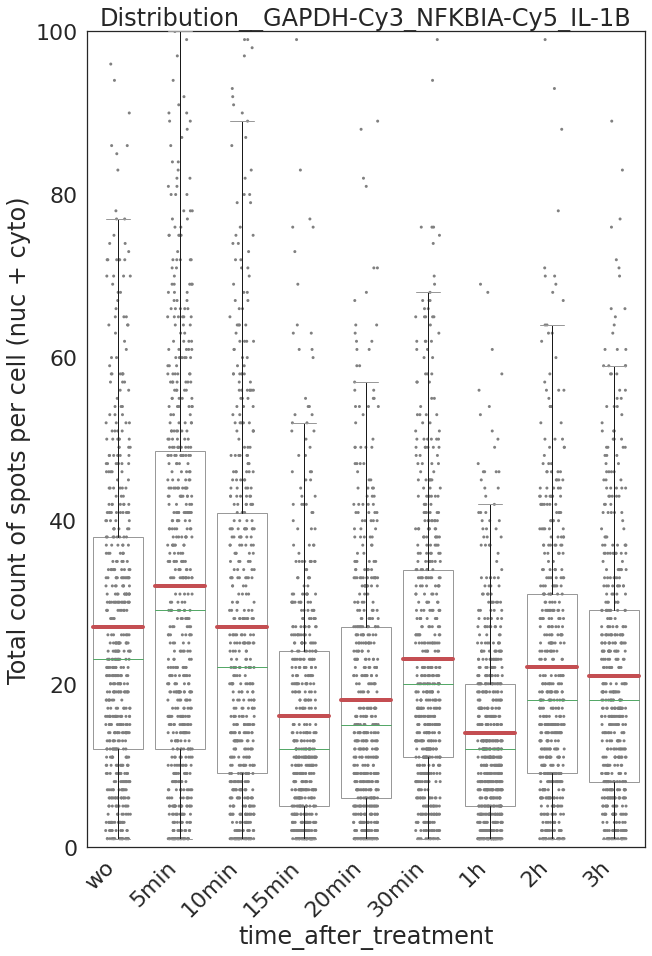

In [17]:
plt.figure(figsize=(10,15))
sns.set(font_scale = 2)
sns.set_style("white")
color_lines = mpl.cm.plasma(np.linspace(0, 1, len(labels_df)))
p = sns.stripplot(x="condition", y="number_spots", data=df_complete, size=3, color='0.5', jitter=0.2)
plt.xticks(rotation=45, ha="right")
sns.set(font_scale = 2)
p.set_ylim(0,max_val_plots)
bp=sns.boxplot( 
            meanprops={'visible': True,'color': 'r', 'ls': 'solid', 'lw': 4},
            medianprops={'visible': True,'color': 'g', 'ls': 'solid', 'lw': 1},
            whiskerprops={'visible': True, 'color':'k','ls': 'solid', 'lw': 1},
            x="condition",
            y="number_spots",
            data=df_complete,
            showcaps={'visible': False, 'color':'orangered', 'ls': 'solid', 'lw': 1}, # Q1-Q3 25-75%
            ax=p,
            showmeans=True,meanline=True,zorder=10,showfliers=False,showbox=True,linewidth=1,color='w')
p.set_xlabel("time_after_treatment")
p.set_ylabel("Total count of spots per cell (nuc + cyto)")
p.set_title(plot_title)
sns.set(font_scale = 2)
plt.savefig(plot_title+'.png')
plt.show()

Text(0.5, 1.0, 'Distributions')

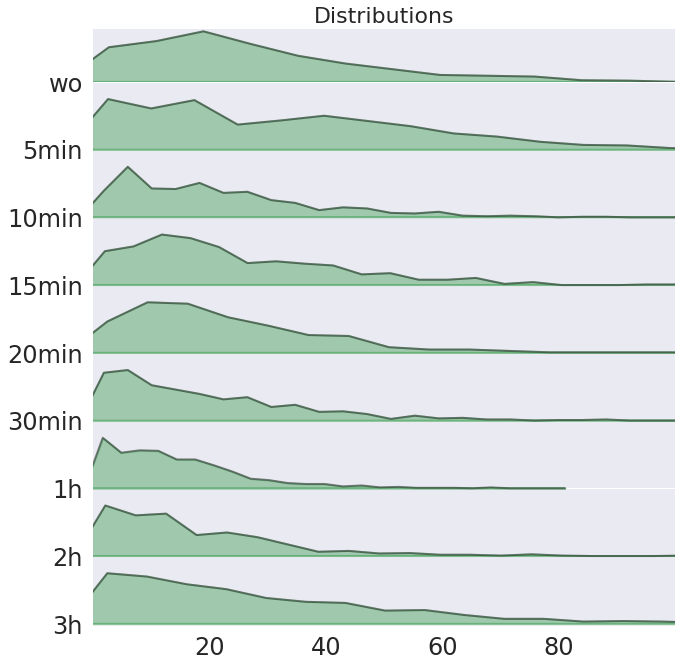

In [18]:
# https://deepnote.com/@deepnote/Joyplot-Introduction-RmbhozJJRC6alCu8xcsbHQ
# https://github.com/leotac/joypy/issues/10
# https://towardsdatascience.com/creating-joy-plots-using-joypy-67327a15eb50
ordered = df_complete.sort_values("condition", ascending=False)
grouped = ordered.groupby("condition", sort=False)
fig, axes = joypy.joyplot(grouped, by="condition", column="number_spots", range_style='own',kind="counts", bins=30,
                          grid="y", linewidth=2, legend=False, figsize=(10,10), labels=labels_df,
                          title="none",ylim='own',alpha=0.5,x_range=[0,max_val_plots],linecolor="k", color="g",overlap=0,
                          colormap=mpl.cm.Blues)
plt.title('Distributions', fontsize=22)


In [19]:
# https://seaborn.pydata.org/tutorial/distributions.html#tutorial-ecdf

In [ ]:
# remove temporary folder
shutil.rmtree(local_folder_path)